# Ejemplo 5.3: Convección-Difusión 1D con Esquema Híbrido (HDS)

Este notebook resuelve el mismo problema de convección-difusión de los ejemplos anteriores, pero utilizando el **Esquema Híbrido (Hybrid Differencing Scheme - HDS)**.

### El Esquema Híbrido

El HDS es un método que intenta combinar las mejores características del esquema de Diferencias Centradas (precisión) y del esquema Upwind (estabilidad). Su lógica se basa en el **Número de Péclet de celda (Pe)**:

- Si **|Pe| < 2**, la difusión es significativa y el CDS es estable. Por lo tanto, el HDS **utiliza el esquema CDS**.
- Si **|Pe| ≥ 2**, la convección domina y el CDS es inestable. Para evitar oscilaciones, el HDS **utiliza el esquema UDS**.

De esta manera, el esquema se adapta localmente a las condiciones del flujo, buscando ser preciso cuando es posible y robusto cuando es necesario.

### Planteamiento del Problema

Se resuelve el caso de **alta velocidad ($u = 2.5 \, m/s$)** con dos mallas diferentes para observar cómo cambia el comportamiento del HDS.

**Ecuación Gobernante:**
$$ \frac{d}{dx}(\rho u \phi) = \frac{d}{dx}\left(\Gamma\frac{d\phi}{dx}\right) $$

**Datos:**
- Longitud, $L = 1.0 \, m$
- Densidad, $\rho = 1.0 \, kg/m^3$
- Coeficiente de difusión, $\Gamma = 0.1 \, kg/(m \cdot s)$
- Condiciones de frontera: $\phi(0) = 1$ y $\phi(L) = 0$.

**Solución Analítica:**
$$ \frac{\phi - \phi_0}{\phi_L - \phi_0} = \frac{e^{(\rho u x / \Gamma)} - 1}{e^{(\rho u L / \Gamma)} - 1} $$


In [1]:
from mnspy import Vertice, Celda, Superficie, VolumenFinito, SuperficieDirichlet, Metodo
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Caso 1: Malla Gruesa (Pe > 2)

Se analiza el caso con una malla de $5$ celdas.
**Cálculo del Número de Péclet:**
- $u = 2.5 \, m/s$
- $\delta x = 0.2 \, m$
- $Pe = \frac{1.0 \times 2.5 \times 0.2}{0.1} = 5.0$

Como **Pe > 2**, se espera que el HDS se comporte **exactamente igual que el esquema Upwind (UDS)**.

### --- Configuración del Problema ---

In [2]:
L = 1.0
n_celdas = 5
phi_0 = 1
phi_L = 0
delta_x = L / n_celdas
Gamma = 0.1
A = 1
dens = 1.0
u = [2.5, 0.0, 0.0]

### --- Discretización ---

In [3]:
v = [Vertice(str(i), i*delta_x) for i in range(n_celdas + 1)]
s = [SuperficieDirichlet('0',[0], {'T': phi_0}, A,u=u)]
for i in range(1, n_celdas):
    s.append(Superficie(str(i),[i], A,u=u))
s.append(SuperficieDirichlet(str(n_celdas),[n_celdas], {'T': phi_L}, A,u=u))
c = [Celda(str(i+1),[i,i+1], gamma=Gamma,densidad=dens) for i in range(n_celdas)]

### --- Solución ---

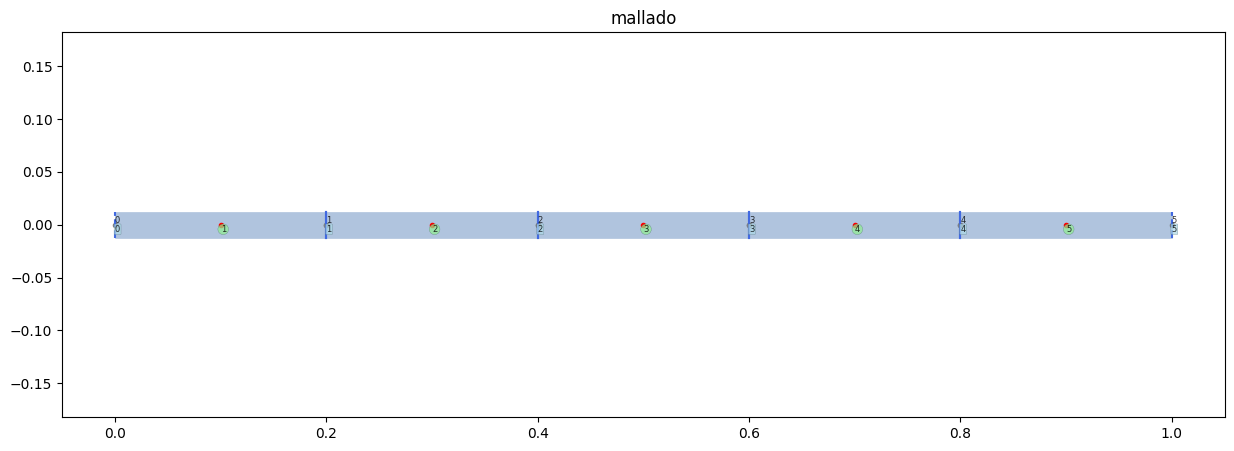

In [4]:
# Se especifica el método Híbrido (HDS).
vol = VolumenFinito(v,s,c, metodo=Metodo.HDS)
vol.mallado()

In [5]:
vol.solucionar_por_Gauss()

## Análisis de Resultados (Caso 1)
### --- Post-procesamiento y Comparación ---

In [6]:
# Función para la solución analítica
def phi_analitica(x, rho, u, Gamma, L, phi_0, phi_L):
    numer = np.exp(rho * u * x / Gamma) - 1
    denom = np.exp(rho * u * L / Gamma) - 1
    if np.isclose(denom, 0): return phi_0 + (phi_L - phi_0) * x / L
    return phi_0 + (phi_L - phi_0) * numer / denom

In [7]:
# Tabla comparativa
x_numeric = np.array([celda.centroide.x for celda in vol.celdas])
phi_numeric = vol.get_solucion().flatten()

datos = {'Distancia': x_numeric, 'Solución FVM (HDS)': phi_numeric}
tabla = pd.DataFrame(datos, index = [c.nombre for c in vol.celdas])
tabla.index.name='Celda'
tabla['Solución Analítica'] = phi_analitica(x_numeric, dens, u[0], Gamma, L, phi_0, phi_L)
tabla['Error Absoluto'] = tabla['Solución Analítica'] - tabla['Solución FVM (HDS)']
tabla['% Error Relativo'] = (100 * np.abs(tabla['Error Absoluto'] / tabla['Solución Analítica'])).map('{:.2f}%'.format)
tabla

,Distancia,Solución FVM (HDS),Solución Analítica,Error Absoluto,% Error Relativo
Celda,,,,,
1,0.1,1.000000,1.000000,-1.553019e-10,0.00%
2,0.3,1.000000,1.000000,-2.509610e-08,0.00%
3,0.5,1.000000,0.999996,-3.726639e-06,0.00%
4,0.7,1.000000,0.999447,-5.530844e-04,0.06%
5,0.9,0.714286,0.917915,2.036293e-01,22.18%


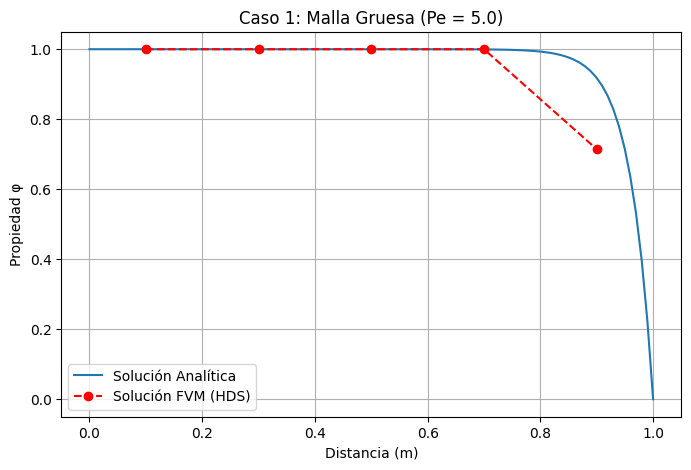

In [8]:
# Gráfica comparativa
x_analytic = np.linspace(0, L, 100)
y_analytic = phi_analitica(x_analytic, dens, u[0], Gamma, L, phi_0, phi_L)

plt.figure(figsize=(8,5))
plt.plot(x_analytic, y_analytic, label='Solución Analítica')
plt.plot(x_numeric, phi_numeric, 'o--', c='r', label='Solución FVM (HDS)')
plt.legend()
plt.grid()
plt.title('Caso 1: Malla Gruesa (Pe = 5.0)')
plt.xlabel('Distancia (m)')
plt.ylabel('Propiedad φ')
plt.show()

**Conclusión (Caso 1):** Como se predijo, el resultado es idéntico al obtenido con el esquema UDS. La solución es estable, pero la difusión numérica introduce un error considerable.

## Caso 2: Malla Fina (Pe < 2)

Ahora se refina la malla a 25 celdas.

**Cálculo del Número de Péclet:**
- $u = 2.5 \, m/s$
- $\delta x = 1.0 / 25 = 0.04 \, m$
- $Pe = \frac{1.0 \times 2.5 \times 0.04}{0.1} = 1.0$

Como **Pe < 2**, se espera que el HDS se comporte **exactamente igual que el esquema de Diferencias Centradas (CDS)**, produciendo una solución precisa.

In [9]:
# --- Configuración y Solución ---
L = 1.0
n_celdas = 25
phi_0 = 1
delta_x = L / n_celdas
Gamma = 0.1
A = 1
dens = 1.0
u = [2.5, 0.0, 0.0]
phi_L = 0

v = [Vertice(str(i), i*delta_x) for i in range(n_celdas + 1)]
s = [SuperficieDirichlet('0',[0], {'T': phi_0}, A,u=u)]
for i in range(1, n_celdas):
    s.append(Superficie(str(i),[i], A,u=u))
s.append(SuperficieDirichlet(str(n_celdas),[n_celdas], {'T': phi_L}, A,u=u))
c = [Celda(str(i+1),[i,i+1], gamma=Gamma,densidad=dens) for i in range(n_celdas)]

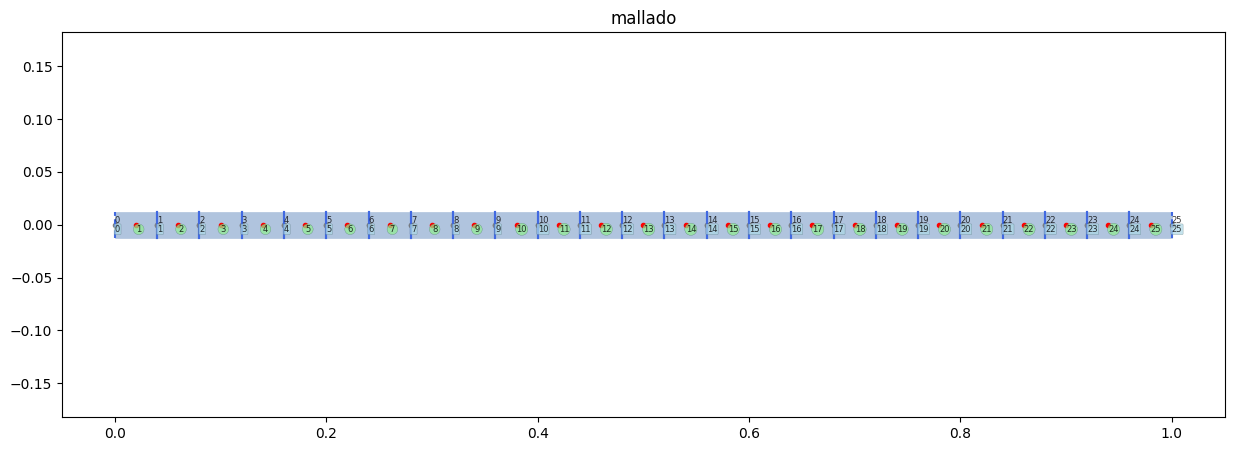

In [10]:
vol = VolumenFinito(v,s,c, metodo=Metodo.HDS)
vol.mallado()

In [11]:
vol.solucionar_por_Gauss()

## Análisis de Resultados (Caso 2)
### --- Post-procesamiento y Comparación ---

In [12]:
x_numeric = np.array([celda.centroide.x for celda in vol.celdas])
phi_numeric = vol.get_solucion().flatten()

datos = {'Distancia': x_numeric, 'Solución FVM (HDS)': phi_numeric}
tabla = pd.DataFrame(datos, index = [c.nombre for c in vol.celdas])
tabla.index.name='Celda'
tabla['Solución Analítica'] = phi_analitica(x_numeric, dens, u[0], Gamma, L, phi_0, phi_L)
tabla['Error Absoluto'] = tabla['Solución Analítica'] - tabla['Solución FVM (HDS)']
tabla['% Error Relativo'] = (100 * np.abs(tabla['Error Absoluto'] / tabla['Solución Analítica'])).map('{:.2f}%'.format)
tabla

,Distancia,Solución FVM (HDS),Solución Analítica,Error Absoluto,% Error Relativo
Celda,,,,,
1,0.02,1.000000,1.000000,-8.222534e-12,0.00%
2,0.06,1.000000,1.000000,-4.284550e-11,0.00%
3,0.10,1.000000,1.000000,-1.356311e-10,0.00%
4,0.14,1.000000,1.000000,-3.838583e-10,0.00%
5,0.18,1.000000,1.000000,-1.046640e-09,0.00%
6,0.22,1.000000,1.000000,-2.812359e-09,0.00%
7,0.26,1.000000,1.000000,-7.504352e-09,0.00%
8,0.30,1.000000,1.000000,-1.993533e-08,0.00%
9,0.34,1.000000,1.000000,-5.275667e-08,0.00%


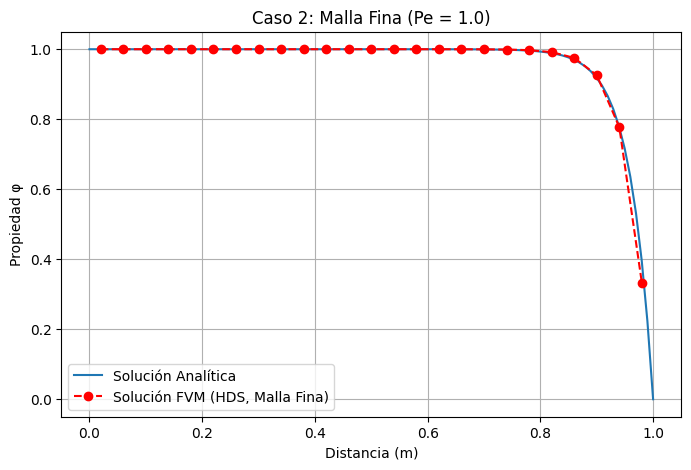

In [13]:
# Gráfica comparativa
x_analytic = np.linspace(0, L, 100)
y_analytic = phi_analitica(x_analytic, dens, u[0], Gamma, L, phi_0, phi_L)

plt.figure(figsize=(8,5))
plt.plot(x_analytic, y_analytic, label='Solución Analítica')
plt.plot(x_numeric, phi_numeric, 'o--', c='r', label='Solución FVM (HDS, Malla Fina)')
plt.legend()
plt.grid()
plt.title('Caso 2: Malla Fina (Pe = 1.0)')
plt.xlabel('Distancia (m)')
plt.ylabel('Propiedad φ')
plt.show()

**Conclusión (Caso 2):** Al refinar la malla, el HDS cambia su comportamiento y ahora coincide con la solución del CDS, que es muy precisa para este Péclet bajo.

### Conclusiones Generales sobre el Esquema Híbrido

1.  **Robustez:** El HDS es un esquema robusto que siempre produce soluciones físicamente realistas, evitando las oscilaciones del CDS en mallas gruesas.
2.  **Precisión Adaptativa:** Cambia a un esquema de mayor precisión (CDS) cuando las condiciones lo permiten (Pe < 2), lo que lo hace superior al UDS en mallas finas.
3.  **Desventaja:** El cambio entre esquemas es abrupto. En cuanto Pe ≥ 2, la precisión cae a primer orden, lo que puede ser una desventaja en problemas complejos donde el Péclet varía a lo largo del dominio.

El HDS fue un esquema popular por su simplicidad y robustez, pero su pérdida de precisión en flujos de alta convección llevó al desarrollo de esquemas más sofisticados como **QUICK**.